Script for Figure 2

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataa.d_config import INDIR, lat_res, lon_res
from utils.make_nsgev import get_vdistr_norm
from utils.misc import natural_keys
from cmip6.treat_data.make_domainwise_am_series import load_am_series_domain
from cmip6.ns_gev.future.all_mems.fit_nsgev_freexi_future_all_mems_rversion_extRemes import load_nsgev_params_freexi_cmip_future_all_mems
from cmip6.fdt.point.compute_drr_analytically import load_analytical_drr

CANNOT IMPORT ISMEVs
R sink error


R[write to console]: Loading required package: Lmoments

R[write to console]: Loading required package: distillery

R[write to console]: 
Attaching package: ‘extRemes’


R[write to console]: The following objects are masked from ‘package:stats’:

    qqnorm, qqplot




Done


In [2]:
### CST ###

yref = 2020
ts2plot = [20, 100]

In [3]:
ds ='CMIP6'
src = 'CanESM5'
ssp_exp = 'ssp245'
nmems = 10
params = ['loc', 'scale']
ymin = 1950
ymax = 2100
lat_pt = 48.75
lon_pt = 2.9
rrf = 2.
nd = None

params_ = "-".join(params)

lat_res_ = lat_res[ds][ssp_exp][src]
lon_res_ = lon_res[ds][ssp_exp][src]

res_ = str(lat_res_) + "x" + str(lon_res_)

years = np.arange(ymin, ymax+1, 1)

if nd:
    nd_ = '_' + str(nd) + 'd'
else:
    nd_ = ''

iyref = np.where(years == yref)[0][0]

In [4]:
data_path = INDIR + '/' + ds + '/' + 'MIROC6' + '/' + ssp_exp
mems = os.listdir(data_path)
mems.sort(key=natural_keys)

orig_pars = load_nsgev_params_freexi_cmip_future_all_mems(ds=ds, source=src, experiment=ssp_exp, nmembers=nmems, lat_res=lat_res_, lon_res=lon_res_, params=params, ymin=ymin, ymax=ymax, ndays=nd)
drrs = load_analytical_drr(ds, src, ssp_exp, lat_res_, lon_res_, params, nmems, ymin, ymax, rrf)

coords = list(orig_pars.keys())

lats = np.unique([coord[0] for coord in coords])
lons = np.unique([coord[1] for coord in coords])

idx_lat_pt = (np.abs(lats - lat_pt)).argmin()
idx_lon_pt = (np.abs(lons - lon_pt)).argmin()

lat_pt_ = lats[idx_lat_pt]
lon_pt_ = lons[idx_lon_pt]
coord_ = (lat_pt_, lon_pt_)
coord_

(48.83524096625064, 2.8125)

In [5]:
orig_pars_ = orig_pars[coord_]
drrs_ = drrs[coord_][yref]

orig_pars_.pop('succes')
orig_pars_.pop('nllh')

loc = orig_pars_['loc']
scale = orig_pars_['scale']
xi = -orig_pars_['c']

nsd_orig = get_vdistr_norm('gev', orig_pars_, years)

r1i1p1f1 : r2i1p1f1 : r3i1p1f1 : r4i1p1f1 : r5i1p1f1 : r6i1p1f1 : r7i1p1f1 : r8i1p1f1 : r9i1p1f1 : r10i1p1f1 : 

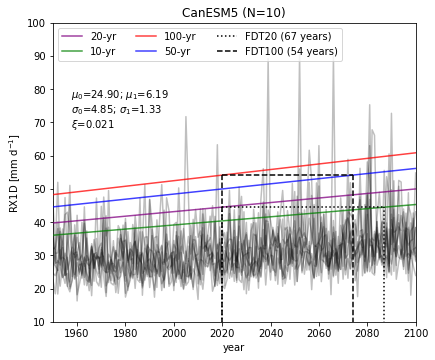

In [10]:
tscols = {10.: 'g', 20.: 'purple', 50.: 'b', 100.: 'r'}
ls = {20.: ':', 100.: '--'}

fig, ax = plt.subplots()

for mem in mems:
    print(mem, end=' : ', flush=True)

    ams_hist = load_am_series_domain(ds, src, 'historical', mem, lat_res_, lon_res_)
    ams_hist_ = ams_hist[coord_]
    ams_ssp = load_am_series_domain(ds, src, ssp_exp, mem, lat_res_, lon_res_)
    ams_ssp_ = ams_ssp[coord_]
    ams_all = pd.concat([ams_hist_, ams_ssp_], axis=0)

    ax.plot(years, ams_all.values, color='k', alpha=0.25)

drrs_orig_ts = []
ls2 = []


for t0 in ts2plot:
    t1 = t0 / rrf
    rls0 = [d.return_level(t0) for d in nsd_orig]
    rls1 = [d.return_level(t1) for d in nsd_orig]
    rl0_orig = rls0[iyref]

    drr = round(drrs_[t0], 0)

    ax.plot(years, rls0, lw=1.5, color=tscols[t0], alpha=0.75, label='%i-yr'%t0, zorder=100)
    ax.plot(years, rls1, lw=1.5, color=tscols[t1], alpha=0.75, label='%i-yr'%t1, zorder=100)

    ls2.append('FDT%i (%i years)'%(t0, drr))

    ax.vlines(yref, 0, rls0[iyref], color='k', linestyle=ls[t0], zorder=200)
    ax.vlines(yref+drr, 0, rls0[iyref], color='k', linestyle=ls[t0], zorder=200)
    ax.hlines(rls0[iyref], years[iyref], years[iyref]+drr, color='k', linestyle=ls[t0], label='FDT%i (%i years)'%(t0, drr), zorder=200)

ax.text(0.05, 0.75, '$\mu_0$=%.2f; $\mu_1$=%.2f'%(orig_pars_['loc'][1], orig_pars_['loc'][0]), transform=ax.transAxes)
ax.text(0.05, 0.70, '$\sigma_0$=%.2f; $\sigma_1$=%.2f'%(orig_pars_['scale'][1], orig_pars_['scale'][0]), transform=ax.transAxes)
ax.text(0.05, 0.65, '$\\xi$=%.3f'%(-orig_pars_['c']), transform=ax.transAxes)
        
ax.set_xlabel('year')
ax.set_xlim(years[0], years[-1])
ax.set_ylim(10, 100)
ax.set_ylabel('RX1D [mm d$^{-1}$]')

ax.legend(loc='upper left', ncol=3)
ax.set_title('{0} (N={1})'.format(src, nmems))

fig.set_size_inches(6.5, 5.5)